In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import gensim
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

<b>Dataset

In [2]:
# Read the Dataset
dataset = pd.read_csv('spamMassages.csv')

# Display the Data
dataset.head(2)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [3]:
# Display the Shape of the Dataset
print('The Shape of the Dataset is : {}'.format(dataset.shape))

The Shape of the Dataset is : (5572, 2)


In [4]:
# Find out the Missing Values in the Dataset
nan_values = dataset.isnull().sum()
print(nan_values)

Category    0
Message     0
dtype: int64


In [5]:
# Find out the Duplicated Data from Dataset
dupData = dataset.duplicated().sum()
print('Total Duplicated Row in the Dataset is : {}'.format(dupData))

Total Duplicated Row in the Dataset is : 415


In [6]:
# Drop the Duplicated Data from Dataset
dataset.drop_duplicates(inplace = True)

# Display the shape After drop the Duplicated Data
print('Shape of the Dataset is : {}'.format(dataset.shape))

Shape of the Dataset is : (5157, 2)


In [7]:
# Count the each class label
classLabel = dataset['Category'].value_counts()
print(classLabel)

ham     4516
spam     641
Name: Category, dtype: int64


<b> Text Pre-processing

In [8]:
# Load the Spacy Pre-Trained Model
nlp = spacy.load('en_core_web_sm')

In [9]:
def textPreprocessing(text):
    doc = nlp(text)
    filterTokens = []
    
    for token in doc:
        if token.like_num or token.is_stop or token.is_punct:
            continue
        filterTokens.append(token.lemma_.lower())
    return filterTokens

In [10]:
# Now map the textPreprocessing funtion on Message Column
dataset['cleanMessage'] = dataset['Message'].map(textPreprocessing)

<b>Implementation of Word2Vec Scratch

In [11]:
# Create the Word2Vec Model
model = gensim.models.Word2Vec(
    window = 6,
    min_count = 2
)

In [12]:
# Build the Vocabulary 
model.build_vocab(dataset['cleanMessage'])

In [13]:
# Now Train the Word2Vec Model
model.train(dataset['cleanMessage'] , total_examples = model.corpus_count , epochs = model.epochs)

(161709, 205325)

In [14]:
# Now Find out the length of the Vocabulary Words
lenVocab = len(model.wv.index_to_key)
print('The total length of the vocabulary is : {}'.format(lenVocab))

The total length of the vocabulary is : 3055


In [15]:
# Now Display the Unique Words
print(model.wv.index_to_key)

['u', ' ', 'ur', 'go', 'come', 'not', 'know', 'good', 'get', 'ok', 'lt;#&gt', 'free', 'like', 'send', 'want', '£', 'time', 'day', 'love', 'text', 'tell', 'think', 'need', 'ü', 'lor', 'home', 'today', 'stop', 'txt', 'reply', 'r', 'n', 'hi', 'da', 'new', 'sorry', 'phone', 'ask', 'mobile', 'work', 'say', 'hope', 'week', 'night', 'hey', 'miss', 'oh', 'wait', 'thing', 'meet', 'try', 'wat', 'great', 'thank', 'leave', 'number', 'later', 'win', 'happy', 'dear', 'min', 'claim', 'way', 'message', 'find', 's', 'k', 'msg', 'let', 'pls', 'feel', 'friend', 'yeah', '+', 'right', 'e', 'babe', 'yes', 'tomorrow', 'c', 'prize', 'late', 'sleep', 'cash', 'cos', 'buy', 'd', 'pick', 'm', 'lol', 'sure', 'life', 'care', 'look', 'to', 'morning', 'b', 'call', 'finish', 'service', 'contact', 'year', 'watch', 'start', 'end', 'tonight', 'guy', 'tone', 'soon', 'money', 'talk', 'urgent', 'place', 'amp', 'mean', 'award', 'ya', 'wish', 'will', 'dun', 'nokia', 'wan', '150p', 'eat', 'take', 'smile', 'gud', 'word', 'haha'

In [16]:
# Now Display all Unique Words in 2-D Numpy Array
vector2D = model.wv.get_normed_vectors()
print(vector2D)

[[-0.07840784  0.14117071  0.03215149 ... -0.14029837  0.06998999
  -0.01258824]
 [-0.08429155  0.13854551  0.04519656 ... -0.14703262  0.05663832
  -0.0167062 ]
 [-0.0773091   0.14314237  0.02834152 ... -0.1387109   0.07182248
  -0.01471143]
 ...
 [-0.05883862  0.1737859   0.00511504 ... -0.14217882  0.05592942
   0.01232274]
 [-0.08435391  0.07152002  0.08947051 ... -0.18032748  0.09087936
  -0.02828921]
 [-0.15092292  0.09624451 -0.03936766 ... -0.03205094 -0.02489112
  -0.06085729]]


In [17]:
# Find out the Shape of the Vector
needVector = model.wv.get_vector('need').shape
print('Shape of the one Word Vector is : {}'.format(needVector))

Shape of the one Word Vector is : (100,)


<b>AvgWord2Vec (Convert each Sentence into Vector)

In [18]:
def avgWord2Vec(sentence):
    # Return the Vector of the sentence 
    return (np.mean([model.wv.get_vector(word) for word in sentence if word in model.wv.index_to_key] , axis = 0 ))

In [30]:
# Create the Corpus (get the tokens of the Words from Dataset)
Corpus = list(dataset['cleanMessage'])

In [31]:
# Convert the Sentence into Vectors
sentVectors = []
for index in tqdm(range(0,len(Corpus))):
    sentVectors.append(avgWord2Vec(Corpus[index]))

  0%|                                                                                         | 0/5157 [00:00<?, ?it/s]D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████| 5157/5157 [00:00<00:00, 5797.64it/s]


In [38]:
# Now Check the Lenth of Each Vectors
for index in range(0,len(sentVectors)):
    if str(sentVectors[index].shape) == '()':
        sentVectors[index] = sentVectors[0]

In [39]:
# Now Convert the Data into Numpy Array
X = np.array(sentVectors)
Y = dataset.iloc[:,0].values

# Display the Shape of the X & Y Matrix
print('Shape of the X Matrix is : {}'.format(X.shape))
print('Shape of the Y Matrix is : {}'.format(Y.shape))

Shape of the X Matrix is : (5157, 100)
Shape of the Y Matrix is : (5157,)


In [43]:
# Now Stack the X Matrix
X = np.stack(X)

# convert the categorical data into numerical data
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

# Now Display the Shape of the X & Y Matrix
print('Shape of the X Matrix is : {}'.format(X.shape))
print('Shape of the Y Matrix is : {}'.format(Y.shape))

Shape of the X Matrix is : (5157, 100)
Shape of the Y Matrix is : (5157,)


<b>Split the Data into Training & Testing

In [45]:
# Now Split the Data
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size = 0.25 , random_state = 42)

In [58]:
# Normalize the Vectors 
normalize = MinMaxScaler()
x_train = normalize.fit_transform(x_train)
x_test  = normalize.fit_transform(x_test)

<b>Machine Learning Model

Accuracy Score of the LR is : 0.9023255813953488



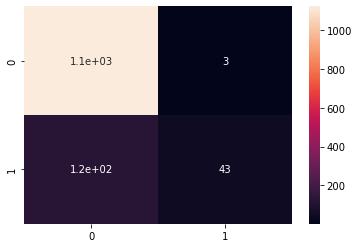

In [59]:
# Model 1 (Logistic Regrssion)
modelLR = LogisticRegression()
modelLR.fit(x_train , y_train)

# Now Predict the Results
y_predLR = modelLR.predict(x_test)

# Calculate the Accuracy Score of the LR Model
accLR = accuracy_score(y_test , y_predLR)
# Display the Accuracy Score of LR
print('Accuracy Score of the LR is : {}\n'.format(accLR))

# Calculate the Confusion Matrix of the LR Model
confLR = confusion_matrix(y_test , y_predLR)
# Display the Confusion Matrix
sns.heatmap(confLR , annot = True)
plt.show()

Accuracy Score of the NB is : 0.8713178294573644



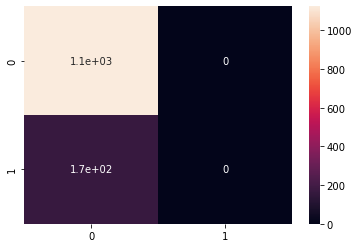

In [60]:
# Model 2 (MultinomialNB)
modelNB = MultinomialNB()
modelNB.fit(x_train , y_train)

# Now Predict the Results
y_predNB = modelNB.predict(x_test)

# Calculate the Accuracy Score of the NB Model
accNB = accuracy_score(y_test , y_predNB)
# Display the Accuracy Score of NB
print('Accuracy Score of the NB is : {}\n'.format(accNB))

# Calculate the Confusion Matrix of the NB Model
confNB = confusion_matrix(y_test , y_predNB)
# Display the Confusion Matrix
sns.heatmap(confNB , annot = True)
plt.show()